In [2]:
#!pip install mlxtend
#!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBRegressor, XGBClassifier
from matplotlib.colors import LinearSegmentedColormap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

## <p style="text-align: center;">See Rob's Code for the Imputation and Encoding Data Cleaning</p>

## <p style="text-align: center;">Remove Highly Correlated Features and Targets </p>

In [114]:
#coloring variables for the two heatmaps
min_color = 'white'
max_color = (0.03137254, 0.18823529411, 0.41960784313, 1)
cmap = LinearSegmentedColormap.from_list("", [min_color, max_color])

In [97]:
#split data into y and x
imputed_and_encoded_data = pd.read_csv('preprocessed_data.csv').drop(columns='Unnamed: 0')
X_and_y = pd.read_csv("x and y Columns.csv")

In [115]:
imputed_and_encoded_data.head()

,X1SEX,X1HISPANIC,X1WHITE,X1BLACK,X1TXMTSCOR,X1TXMPROF1,X1TXMPROF2,X1TXMPROF3,X1TXMPROF4,X1TXMPROF5,...,C1GOAL2_3.0,C1GOAL2_4.0,C1GOAL3_1.0,C1GOAL3_2.0,C1GOAL3_3.0,C1GOAL3_4.0,C1PLAN_1.0,C1PLAN_2.0,C1PLAN_3.0,C1PLAN_4.0
0,1.0,0.0,1.0,0.0,59.3710,0.9997,0.9669,0.8976,0.3126,0.1013,...,0,0,0,0,1,0,0,0,0,1
1,2.0,0.0,1.0,0.0,47.6821,0.9714,0.5204,0.1768,0.0582,0.0512,...,0,1,0,1,0,0,0,0,0,0
2,2.0,0.0,0.0,1.0,64.2431,1.0000,0.9914,0.9838,0.6606,0.2001,...,0,1,0,1,0,0,0,0,1,0
3,2.0,0.0,1.0,0.0,49.2690,0.9843,0.6416,0.2459,0.0662,0.0531,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1.0,0.0,62.5897,0.9999,0.9863,0.9686,0.5385,0.1551,...,1,0,0,1,0,0,0,0,1,0


In [116]:
X = imputed_and_encoded_data.drop(columns=X_and_y['y'].dropna().tolist())
y = imputed_and_encoded_data[X_and_y['y'].dropna().tolist()]

In [117]:
y.shape

(23503, 14)

In [118]:
#find y correlation matrix
corr_sorted = abs(y.corr())
sorted_df = y[list(corr_sorted.index)]
y_corr = round(sorted_df.corr(), 2)

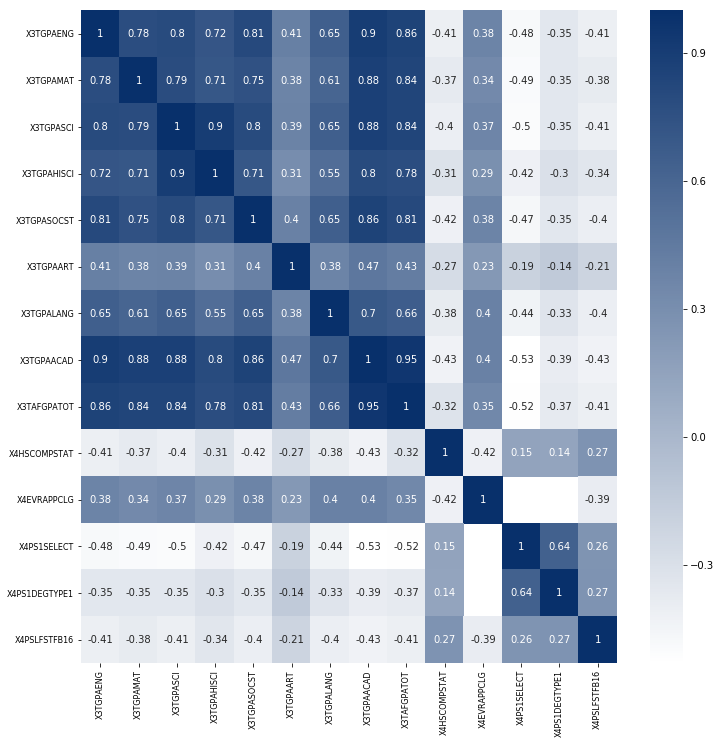

In [119]:
fig, ax = plt.subplots(figsize=(12,12))

fig = sns.heatmap(y_corr, annot=True, cmap=cmap,
                  xticklabels=y_corr.columns.values,
                  yticklabels=y_corr.columns.values,
                  ax = ax)
plt.xticks(rotation=90)
fig.xaxis.set_tick_params(labelsize=8)
fig.yaxis.set_tick_params(labelsize=8)

plt.show()

From the data above we see that the target features are neatly separated into two highly correlated sections. We are going to use the feature, X3TGPAACAD, in the top left box for our regression part of our ensemble. We are going to use X4PS1SELECT from the bottom right correlated box for our classification part.

In [120]:
y_columns_to_keep = ['X3TGPAACAD', 'X4PS1SELECT']

In [121]:
#find x correlation matrix
corr_sorted = abs(X.corr())
sorted_df = X[list(corr_sorted.index)]
X_corr = round(sorted_df.corr(), 2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

fig = sns.heatmap(X_corr, annot=True, cmap=cmap,
                  xticklabels=X_corr.columns.values,
                  yticklabels=X_corr.columns.values,
                  ax = ax)
plt.xticks(rotation=90)
fig.xaxis.set_tick_params(labelsize=8)
fig.yaxis.set_tick_params(labelsize=8)

plt.show()

In [122]:
#find the highly correlated features to eliminate
corr_matrix = pd.DataFrame(X_corr)
corr_col = corr_matrix.columns

counter = pd.DataFrame([[0]*len(corr_col)], columns = corr_col)
count_of_pairs = 0

for x in range(0, len(corr_col)):
    for i in range(x+1, len(corr_col)):
        if abs(X_corr[corr_col[x]][corr_col[i]]) > .90:
            count_of_pairs = count_of_pairs + 1
            counter[corr_col[x]][0] = counter[corr_col[x]][0] + 1
            counter[corr_col[i]][0] = counter[corr_col[i]][0] + 1
            print("(", corr_col[x],",", corr_col[i], ") with a correlation of ", X_corr[corr_col[x]][corr_col[i]])
            
print("The amount of highly correlated pairs is", count_of_pairs)

( X1HISPANIC , X1RACE_5.0 ) with a correlation of  0.93
( X1TXMTSCOR , X1TXMPROF2 ) with a correlation of  0.92
( X1TXMTSCOR , X1TXMPROF3 ) with a correlation of  0.92
( X2TXMPROF2 , X2TXMPROF3 ) with a correlation of  0.95
( X2TXMPROF4 , X2TXMPROF5 ) with a correlation of  0.94
( X2TXMPROF6 , X2TXMPROF7 ) with a correlation of  0.96
( X1DUALLANG_1.0 , S1LANG1ST_1.0 ) with a correlation of  1.0
( X3TCREDCOM_0.0 , X3TGPACOM_-1.0 ) with a correlation of  0.98
The amount of highly correlated pairs is 8


In [123]:
#eliminate features that are too highly correlated
X_columns_to_keep = corr_col[(counter < 2).iloc[0, :]].values
X_columns_to_keep.shape

(1740,)

In [124]:
#Refine data to not have overly correlated features

cleaned_data = imputed_and_encoded_data[np.append(X_columns_to_keep, y_columns_to_keep)]
cleaned_data.shape


(23503, 1742)

In [125]:
def drop_neg_rows(df, column):
    null_array = [np.nan] * len(df[column])
    mask = pd.DataFrame({column: null_array})
    for i in range(0, len(df[column])):
        if str(df[column][i]) == 'nan':
            mask[column][i] = 0
    mask[column].dropna(inplace=True)
    return df.drop(mask[column].index)

In [126]:
#split into Train and Test for the regression
reg_target = y_columns_to_keep[0]

reg_data = cleaned_data[np.append(X_columns_to_keep, reg_target)]
reg_data = drop_neg_rows(reg_data, reg_target)
print(reg_data.shape)

X_reg = reg_data[X_columns_to_keep]
y_reg = reg_data[reg_target]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.33, random_state=1)

(21888, 1741)


In [127]:
#split into Train and Test for the classification
class_target = y_columns_to_keep[1]

class_data = cleaned_data[np.append(X_columns_to_keep, class_target)]
class_data = drop_neg_rows(class_data, class_target)
print(class_data.shape)

X_class = class_data[X_columns_to_keep]
y_class = class_data[class_target]

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.33, random_state=1)

(12957, 1741)


## <p style="text-align: center;">Using Regression to find the most important features</p>

In [128]:
def LinearRegressionFeatureSelection(n_features):
    lin_reg = SFS(LinearRegression(),
          k_features=n_features,
          forward=True,
          floating=False,
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=3)
    lin_reg.fit(X_reg_train, y_reg_train)
    time.sleep(1)
    
    lin_reg_selected_features = LinearRegression()
    lin_reg_selected_features.fit(X_reg_train[list(lin_reg.subsets_[n_features]['feature_names'])],y_reg_train)
    
    features = pd.DataFrame({'Features': lin_reg.subsets_[n_features]['feature_names'], 'Coefs': lin_reg_selected_features.coef_})
    display(features)
    
    lin_reg_fig = plot_sfs(lin_reg.get_metric_dict(), kind='std_err')
    plt.show()
    return features

In [129]:
def LassoRegressionFeatureSelection(n_features):
    lasso = SFS(Lasso(alpha=.1),
          k_features=n_features,
          forward=True,
          floating=False,
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=3)
    lasso.fit(X_reg_train, y_reg_train)
    time.sleep(1)
    
    lasso_reg_selected_features = Lasso(alpha = .1)
    lasso_reg_selected_features.fit(X_reg_train[list(lasso.subsets_[n_features]['feature_names'])],y_reg_train)
    
    features = pd.DataFrame({'Features': lasso.subsets_[n_features]['feature_names'], 'Coefs': lasso_reg_selected_features.coef_})
    display(features)
    
    lin_reg_fig = plot_sfs(lasso.get_metric_dict(), kind='std_err')
    plt.show()
    return features

In [130]:
def XGBRegGBLinearFeatureSelection(n_features):
    xgb = XGBRegressor(booster = 'gblinear')
    xgb.fit(X_reg_train, y_reg_train)
    
    feature_importance = pd.DataFrame({'Features': X_reg_train.columns, 'Coefficients': np.array(xgb.coef_).astype(np.float), 'abs(coefs)': abs(np.array(xgb.coef_).astype(np.float))})
    feature_importance.sort_values(by=['abs(coefs)'], ascending = False, inplace = True)
    feature_importance.drop(feature_importance.tail(len(feature_importance.index)-n_features).index, inplace=True)
    
    display(feature_importance)
    return feature_importance

In [131]:
def XGBRegGBTreeFeatureSelection(n_features):
    xgb = XGBRegressor(booster = 'gbtree')
    xgb.fit(X_reg_train, y_reg_train)
    
    feature_importance = pd.DataFrame({'Features': X_reg_train.columns, 'Coefficients': np.array(xgb.feature_importances_).astype(np.float)})
    feature_importance.sort_values(by=['Coefficients'], ascending = False, inplace = True)
    feature_importance.drop(feature_importance.tail(len(feature_importance.index)-n_features).index, inplace=True)
    
    display(feature_importance)
    return feature_importance

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1740 out of 1740 | elapsed:    8.4s finished

[2018-12-14 14:30:25] Features: 1/10 -- score: -0.57303123537158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1739 out of 1739 | elapsed:   11.6s finished

[2018-12-14 14:30:36] Features: 2/10 -- score: -0.42792895191830915[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1738 out of 1738 | elapsed:   12.5s finished

[2018-12-14 14:30:49] Features: 3/10 -- score: -0.4036136100967238[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]

,Features,Coefs
0,X1SEX,0.227383
1,X1TXMPROF2,0.398698
2,X1SES_U,0.104561
3,X2TXMTSCOR,0.022578
4,X2BEHAVEIN,0.114470
5,X3TCREDTOT,0.043622
6,X3TCREDAPENG_0.0,-0.205489
7,S1NOHWDN_1.0,0.182248
8,S1NOHWDN_3.0,-0.184509
9,P1PERFORM_1.0,0.225272


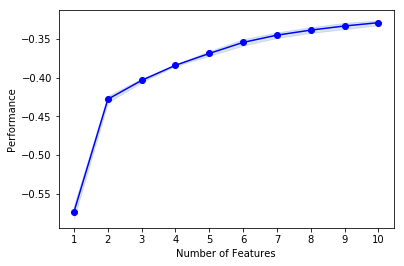

In [132]:
#REGRESSION
linear_reg_features = LinearRegressionFeatureSelection(10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1740 out of 1740 | elapsed:    8.1s finished

[2018-12-14 14:33:21] Features: 1/10 -- score: -0.5732155974125734[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1739 out of 1739 | elapsed:    9.4s finished

[2018-12-14 14:33:31] Features: 2/10 -- score: -0.4281782129065494[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1738 out of 1738 | elapsed:   12.8s finished

[2018-12-14 14:33:44] Features: 3/10 -- score: -0.4174399576433461[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)

,Features,Coefs
0,X1SCHOOLENG,0.024467
1,X2TXMTSCOR,0.033672
2,X2BEHAVEIN,0.024194
3,X3TCREDART,0.007033
4,X3TCREDTOT,0.049180
5,X3TCREDADV,0.021688
6,X3TCREDHON,0.023298
7,P1HOURS1,-0.000432
8,M1SCHYRS,0.000716
9,C1CASELOAD,-0.000234


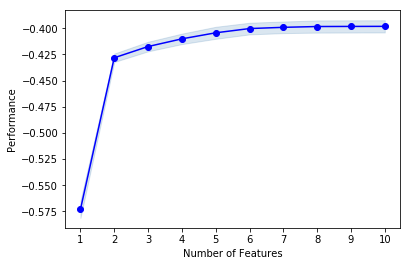

In [133]:
lasso_reg_features = LassoRegressionFeatureSelection(10)

In [134]:
xgb_linear_reg_features = XGBRegGBLinearFeatureSelection(10)

,Features,Coefficients,abs(coefs)
38,X2BEHAVEIN,0.050119,0.050119
0,X1SEX,0.041000,0.041000
39,X2MEFFORT,0.037512,0.037512
46,X3TCREDSCI,0.036921,0.036921
48,X3TCREDART,0.035401,0.035401
45,X3TCREDMAT,0.034649,0.034649
969,P1PERFORM_1.0,0.032816,0.032816
21,X1SCHOOLENG,0.032346,0.032346
44,X3TCREDENG,0.028087,0.028087
5,X1TXMPROF2,0.026414,0.026414


In [135]:
xgb_tree_reg_features = XGBRegGBTreeFeatureSelection(10)

,Features,Coefficients
49,X3TCREDTOT,0.052857
29,X2TXMTSCOR,0.048571
38,X2BEHAVEIN,0.047143
48,X3TCREDART,0.031429
0,X1SEX,0.027143
315,X1REGION_3,0.022857
51,X3TCRED10TH,0.022857
39,X2MEFFORT,0.020000
55,X3TCREDHON,0.020000
45,X3TCREDMAT,0.020000


## <p style="text-align: center;">Using Classification to find the most important features</p>

In [136]:
def XGBClassifierFeatureSelection(n_features):
    xgb = XGBClassifier()
    xgb.fit(X_class_train, y_class_train)
    
    feature_importance = pd.DataFrame({'Features': X_class_train.columns, 'Coefficients': np.array(xgb.feature_importances_).astype(np.float)})
    feature_importance.sort_values(by=['Coefficients'], ascending = False, inplace = True)
    feature_importance.drop(feature_importance.tail(len(feature_importance.index)-n_features).index, inplace=True)
    
    display(feature_importance)
    return feature_importance

In [137]:
def RandomForestClassifierFeatureSelection(n_features):
    rf = RandomForestClassifier()
    rf.fit(X_class_train, y_class_train)
    
    feature_importance = pd.DataFrame({'Features': X_class_train.columns, 'Coefficients': np.array(rf.feature_importances_).astype(np.float)})
    feature_importance.sort_values(by=['Coefficients'], ascending = False, inplace = True)
    feature_importance.drop(feature_importance.tail(len(feature_importance.index)-n_features).index, inplace=True)
    
    display(feature_importance)
    return feature_importance

In [138]:
def ExtraTreesFeatureSelection(n_features):
    ext_clf = ExtraTreesClassifier(n_estimators = 125, n_jobs = -1)
    ext_clf.fit(X_class_train, y_class_train)
    
    feature_importance = pd.DataFrame({'Features': X_class_train.columns, 'Coefficients': np.array(ext_clf.feature_importances_).astype(np.float)})
    feature_importance.sort_values(by=['Coefficients'], ascending = False, inplace = True)
    feature_importance.drop(feature_importance.tail(len(feature_importance.index)-n_features).index, inplace=True)
    
    display(feature_importance)
    return feature_importance

In [139]:
extra_trees_class_features = ExtraTreesFeatureSelection(10)

,Features,Coefficients
33,X2TXMPROF4,0.008436
34,X2TXMPROF5,0.007807
426,X3TCREDAPSS_0.0,0.005575
35,X2TXMPROF6,0.005224
425,X3THISCI_5.0,0.004959
153,P1HONORS,0.004743
393,X3TCREDAPMTH_0.0,0.004434
6,X1TXMPROF3,0.004246
387,X3TCREDAPENG_0.0,0.004191
7,X1TXMPROF4,0.004116


In [140]:
xgb_class_features = XGBClassifierFeatureSelection(10)

,Features,Coefficients
29,X2TXMTSCOR,0.043730
11,X1SES_U,0.036482
249,A2HIGHERED,0.025610
41,X2PROBLEM,0.020295
54,X3TCREDADV,0.018845
38,X2BEHAVEIN,0.015704
55,X3TCREDHON,0.013530
46,X3TCREDSCI,0.013530
1075,P2TYPEPS2013_2.0,0.013530
42,X2SCHOOLCLI,0.012322


In [141]:
random_forest_class_features = RandomForestClassifierFeatureSelection(10)

C:\Users\trevo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Features,Coefficients
29,X2TXMTSCOR,0.016249
36,X2TXMPROF7,0.015886
31,X2TXMPROF2,0.013427
30,X2TXMPROF1,0.011299
54,X3TCREDADV,0.011008
249,A2HIGHERED,0.010962
32,X2TXMPROF3,0.010087
34,X2TXMPROF5,0.009285
11,X1SES_U,0.009085
41,X2PROBLEM,0.008870


## <p style="text-align: center;">Ensemble Attempt (Combiner)</p>

In [142]:
union_of_all_features = list(set().union(linear_reg_features['Features'], lasso_reg_features['Features'], xgb_linear_reg_features['Features'], xgb_tree_reg_features['Features'], extra_trees_class_features['Features'], xgb_class_features['Features'], random_forest_class_features['Features']))

In [150]:
def drop_neg_tot_rows(df, column):    
    null_array = [np.nan] * len(df[column])
    mask = pd.DataFrame({column: null_array}, index = df.index)
    for i in df.index:
        if str(df[column][i]) == 'nan':
            mask[column][i] = 0
    mask[column].dropna(inplace=True)
    return df.drop(mask[column].index)

In [151]:
#Find the most important feature of the combined models' best features
cleaned_tot_data = cleaned_data[np.append(X_columns_to_keep, y_columns_to_keep)]

half_neg_dropped = drop_neg_tot_rows(cleaned_tot_data, y_columns_to_keep[0])
full_neg_dropped = drop_neg_tot_rows(half_neg_dropped, y_columns_to_keep[1])

X = full_neg_dropped[X_columns_to_keep]
y = full_neg_dropped[y_columns_to_keep]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

In [159]:
lin_reg = SFS(LinearRegression(),
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=3)
lin_reg.fit(X_train, y_train)
time.sleep(1)
    
lin_reg_selected_features = LinearRegression()
lin_reg_selected_features.fit(X_train[list(lin_reg.subsets_[10]['feature_names'])],y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1740 out of 1740 | elapsed:   16.7s finished

[2018-12-14 15:03:23] Features: 1/10 -- score: -1.255061410668169[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1739 out of 1739 | elapsed:   18.1s finished

[2018-12-14 15:03:41] Features: 2/10 -- score: -1.1827666987032406[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1738 out of 1738 | elapsed:   21.4s finished

[2018-12-14 15:04:02] Features: 3/10 -- score: -1.1300309148127459[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]

('X1SES_U',
 'X1CONTROL',
 'X2TXMTSCOR',
 'X2BEHAVEIN',
 'X3TCREDSCI',
 'X3TCREDHON',
 'S1FYBA',
 'X3TCREDAPSS_0.0',
 'P1PERFORM_1.0',
 'P2TYPEPS2013_2.0')

In [163]:
features = pd.DataFrame({'Features': lin_reg.subsets_[10]['feature_names'], 'Coefs_X3TGPAACAD': lin_reg_selected_features.coef_[0], 'Coefs_X4PS1SELECT': lin_reg_selected_features.coef_[1]})
display(features)

,Features,Coefs_X3TGPAACAD,Coefs_X4PS1SELECT
0,X1SES_U,0.074598,-0.320049
1,X1CONTROL,0.059043,-0.475153
2,X2TXMTSCOR,0.024611,-0.039299
3,X2BEHAVEIN,0.166175,-0.114299
4,X3TCREDSCI,0.101136,-0.170056
5,X3TCREDHON,0.017184,-0.036519
6,S1FYBA,0.121411,-0.372151
7,X3TCREDAPSS_0.0,-0.110478,0.470575
8,P1PERFORM_1.0,0.276345,-0.249375
9,P2TYPEPS2013_2.0,-0.120578,0.953380


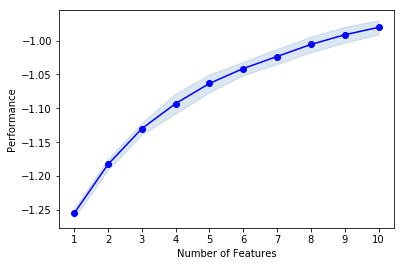

In [161]:
lin_reg_fig = plot_sfs(lin_reg.get_metric_dict(), kind='std_err')
plt.show()